In [70]:

import numpy as np
import math
import matplotlib.pyplot as plt
import random
import timeit
import scipy.fftpack
import scipy.io as sio
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import interpolate
from PIL import Image
from skimage import filters
import scipy.ndimage as ndimage
import random
import imreg_dft as ird
from dipy.data import get_fnames
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools
from skimage.transform import resize
from scipy.ndimage import affine_transform, rotate
import scipy.optimize as optimize

# Generate Blank Staff

In [2]:
def load(name):
    music = np.asarray(Image.open(name))
    red = music[..., 0]
    green = music[..., 1]
    blue = music[..., 2]

    music = 0.21 * red + 0.72 * green + 0.07 * blue
    
    thresh = filters.threshold_otsu(music)+60
    music[music > thresh]=255
    music[music <= thresh]=0
    
    music=music.astype(np.uint8)
    return music

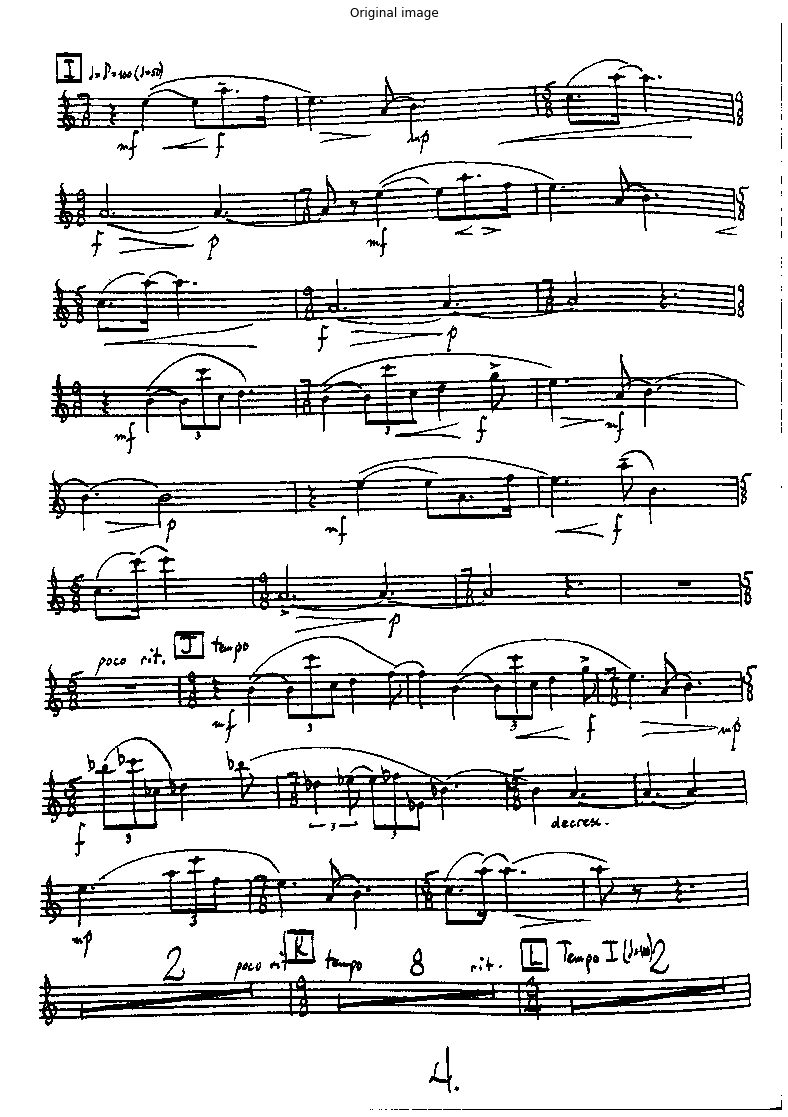

In [3]:
music = load("nc4.jpg")
# plot original image
plt.figure(figsize=(30, 20))
plt.imshow(music, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original image')

plt.show()

In [4]:
#white background black content
def find_max_run(arr1, color):
    arr=arr1.astype(int)
    # make sure all runs of ones are well-bounded
    flat = arr.flatten("F")
    if color == 'black':
        #set ends as white
        flat[0]=np.max(flat)
        flat[len(flat)-1]=np.max(flat)
    elif color == 'white':
        flat[0]=np.min(flat)
        flat[len(flat)-1]=np.min(flat)        
    #print(flat)
    # get 1 at run starts and -1 at run ends
    difs = np.diff(flat)
    
    #print(difs)
    #print(np.max(difs))
    #print(np.min(difs))
    run_starts = np.where(difs > 0)[0]
    run_ends = np.where(difs < 0)[0]
    if color == "black":
        runlengths =  run_starts - run_ends
    elif color == 'white':
        runlengths = run_ends-run_starts
    print(runlengths)
    return np.abs(scipy.stats.mode(runlengths)[0][0]), runlengths

In [5]:
arr = np.ones((10,10))
arr[1:4, 2:5]=0
arr[0:2, 6:9]=0

In [6]:
arr

array([[1., 1., 1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [7]:
lenght, runlenghs = find_max_run(arr, 'white')

[20  7  7 16  8  8 17]


In [8]:
scipy.stats.mode(runlenghs)

ModeResult(mode=array([7]), count=array([2]))

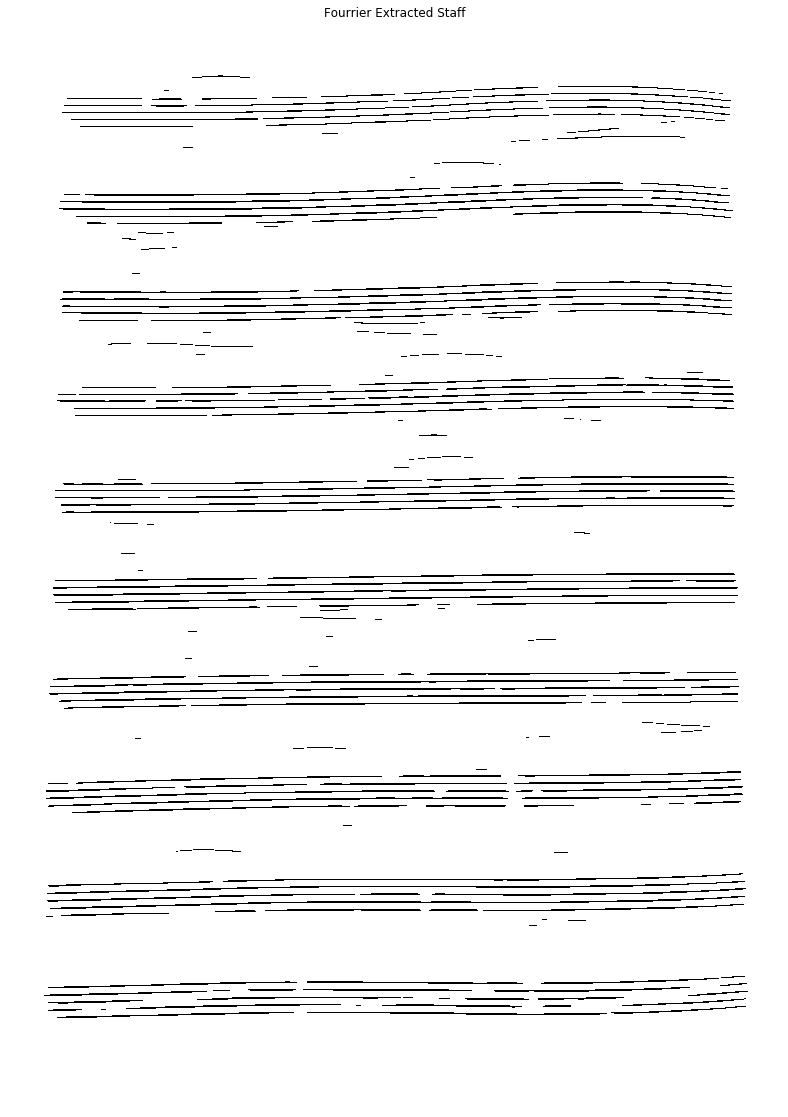

In [9]:
extracted_staff = np.asarray(Image.open("extracted.png"))

plt.figure(figsize=(30, 20))
plt.imshow(extracted_staff, cmap=plt.cm.gray)
plt.axis('off')
plt.title('Fourrier Extracted Staff')

plt.show()

In [10]:
#find onset location (optimize )
def calc_onset(staff):
    forward_onset_total = 0
    backward_onset_total = 0
    i=0
    for rownum in range(0, staff.shape[0]):
        row = staff[rownum, 0:staff.shape[1]-1]
        onsets = np.where(row == 0)
        if len(onsets[0]) != 0:
              
            i+=1
            forward_onset = onsets[0][0]
            forward_onset_total += forward_onset
            
            #calculate back_onset
            
            backward_onset = onsets[0][len(onsets[0])-1]
            #print(onsets)
            #print(backward_onset)
            backward_onset_total += backward_onset
    return forward_onset_total/i , backward_onset_total/i
            
            
            
        

In [11]:
onset = calc_onset(music)

In [12]:
onset

(423.8019338739863, 1952.5290081097942)

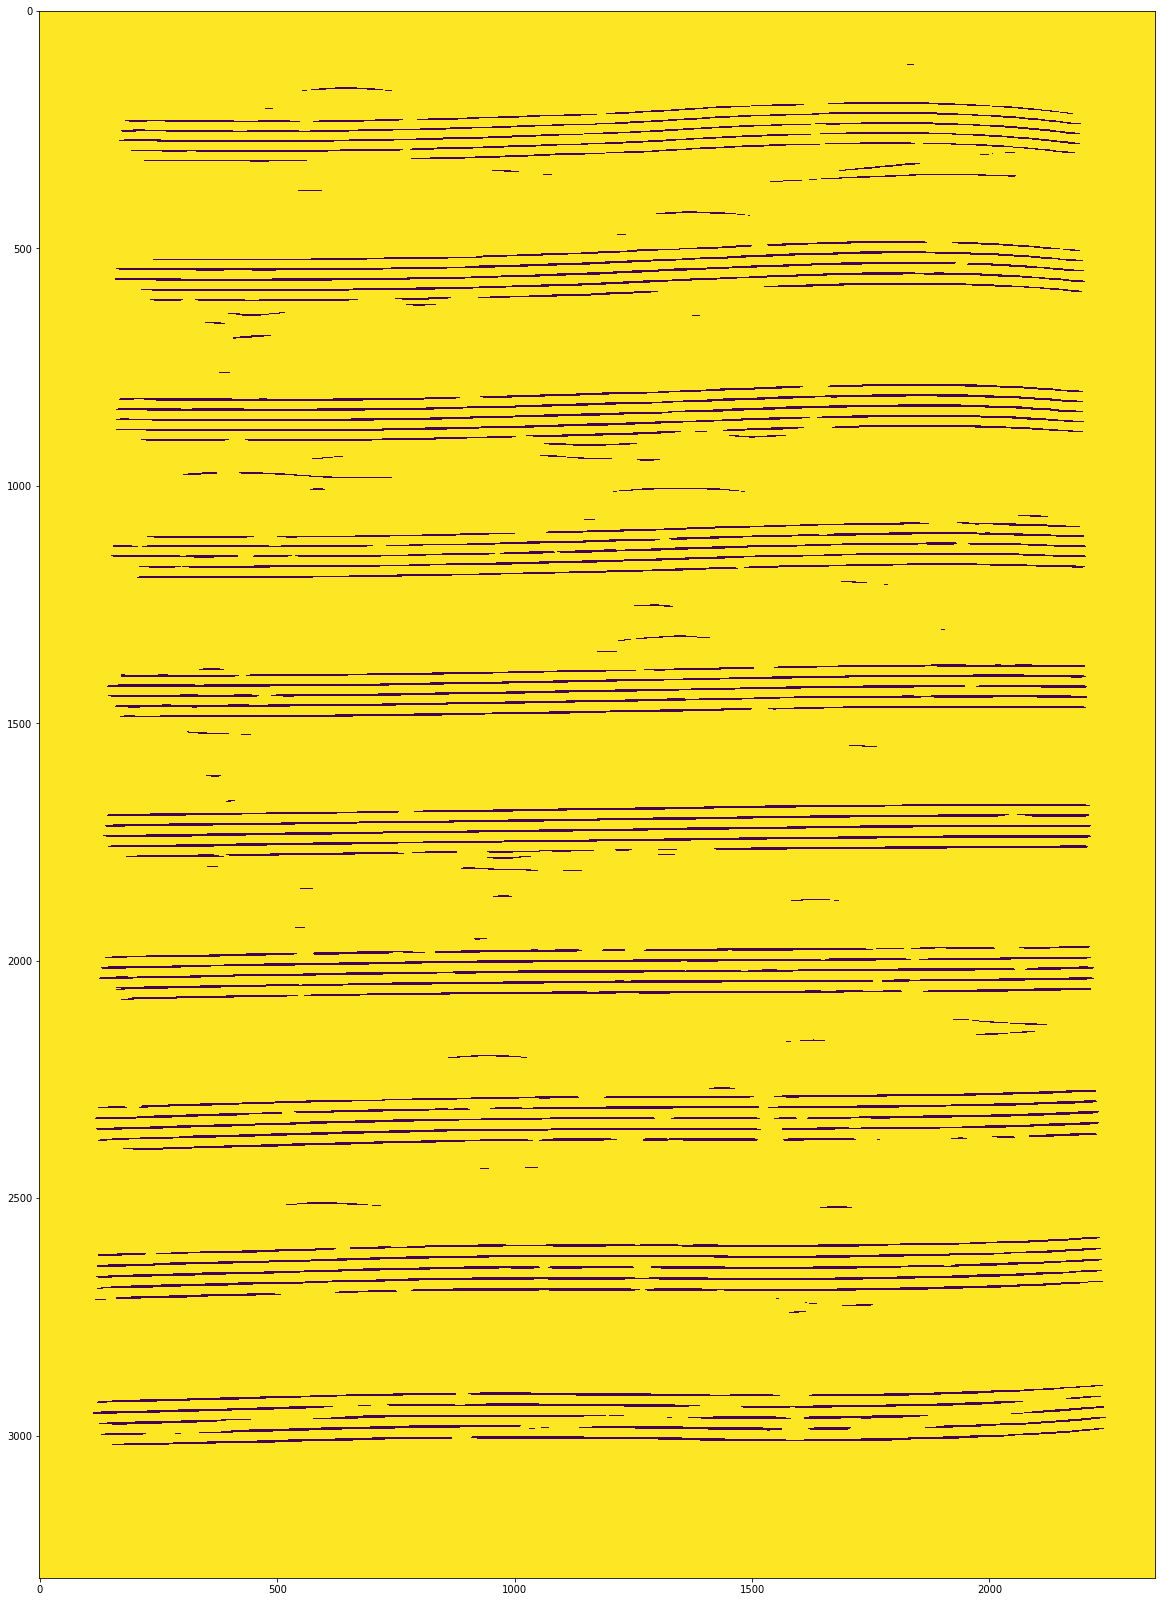

In [13]:
extracted_test = extracted_staff.copy()
extracted_test[0:extracted_test.shape[0]-1, int(onset[0])]=0
extracted_test[0:extracted_test.shape[0]-1, int(onset[1])]=0
plt.figure(figsize=(20,30))
plt.imshow(extracted_test)

In [14]:
def make_blank_img(music):

    staff_iter = 10 # will be caluclated from ccs
    width = int(music.shape[1]*.9)
    #print(width)
    staff_height = find_max_run(music, color="black")[0]
    #print(staff_height)
    space_height = find_max_run(music, color= "white")[0]
    #print(space_height)
    staff_space = np.ones((staff_height+space_height, width))*np.max(music)
    staff_space[0:staff_height]=0
    staff = np.tile(staff_space, (5,1))
    staff_chunk = np.ones((int(staff.shape[0]*2.5), width))*np.max(music)
    staff_chunk[0: staff.shape[0], 0:staff.shape[1]]=staff
    staff_core = np.tile(staff_chunk, (10,1))
    blank_img = np.ones(music.shape)*np.max(music)
    
    x_offset = int((blank_img.shape[0] - staff_core.shape[0])/2)
    y_offset = int((blank_img.shape[1] - staff_core.shape[1])/2)
    print(x_offset)
    blank_img[x_offset:x_offset+staff_core.shape[0], \
              y_offset:y_offset+staff_core.shape[1]] = staff_core
    
    return blank_img
    
    
    
    
    
                    
    


[   1    1    1 ...    6    3 3330]
[3298 3299 3299 ...  159 1841   12]
275


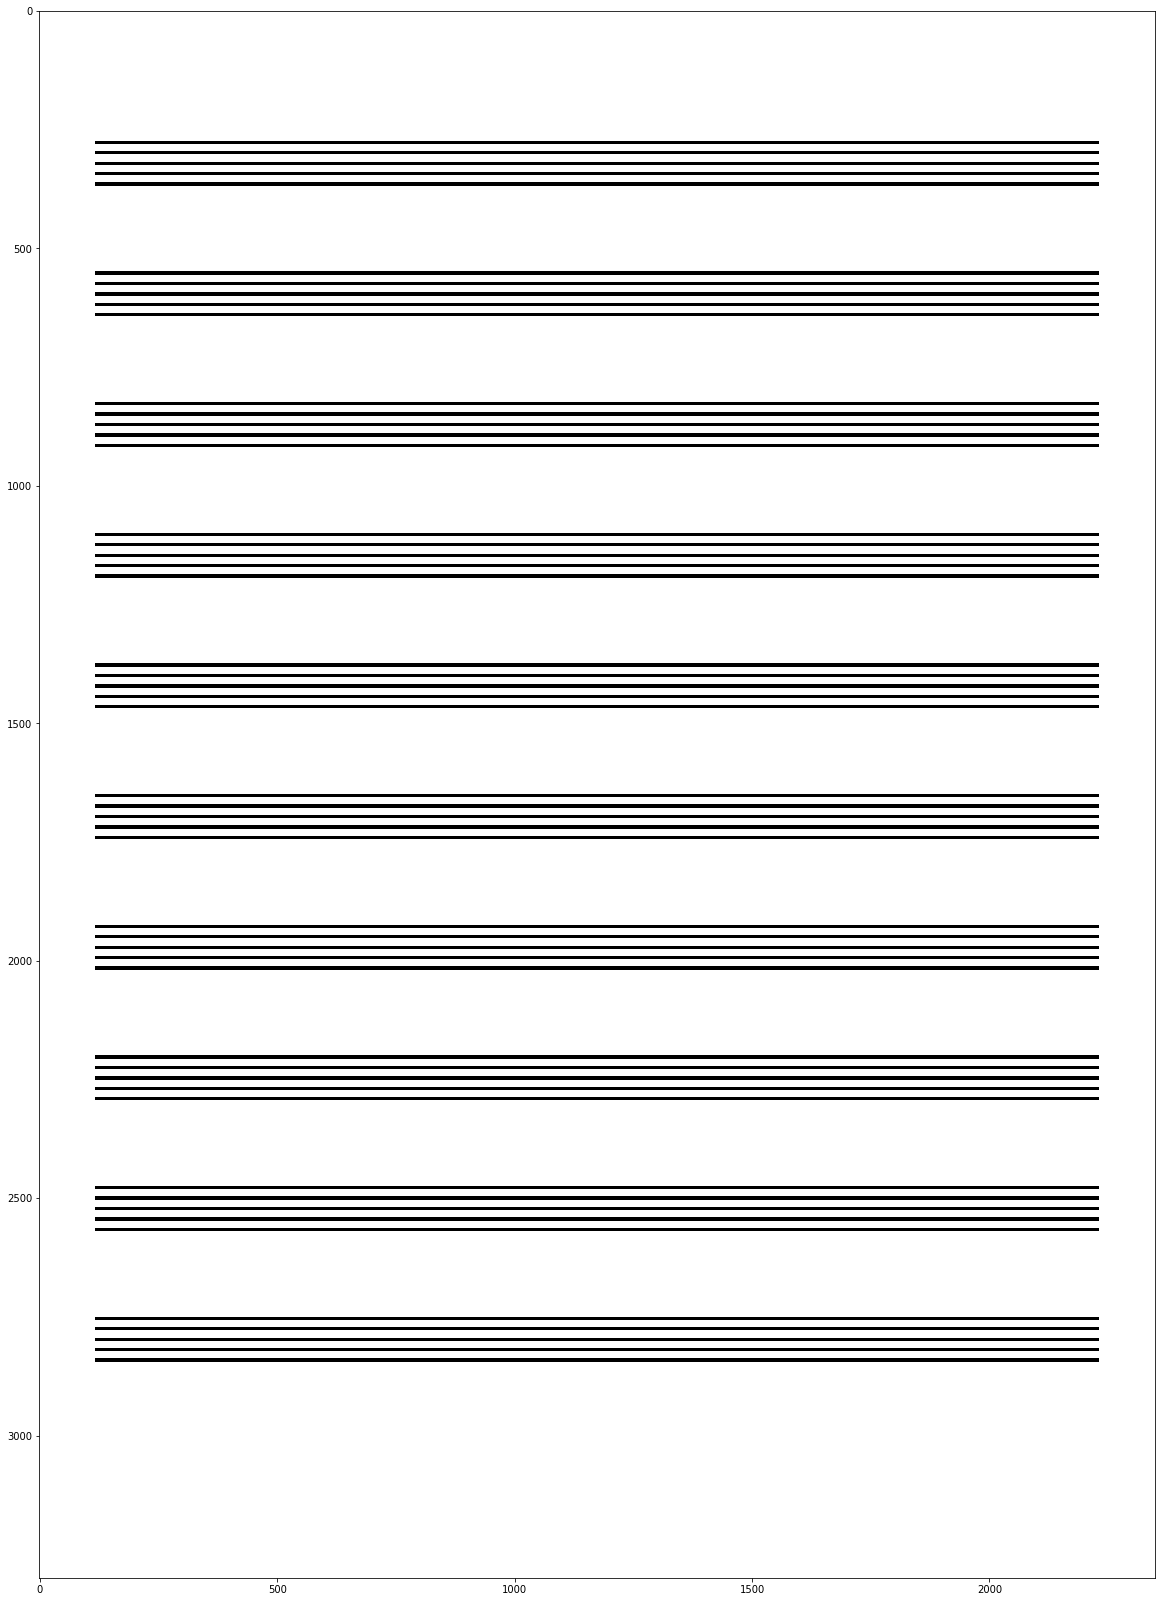

In [61]:
blank_img = make_blank_img(music)
plt.figure(figsize=(20,30))
plt.imshow(blank_img, cmap='gray')

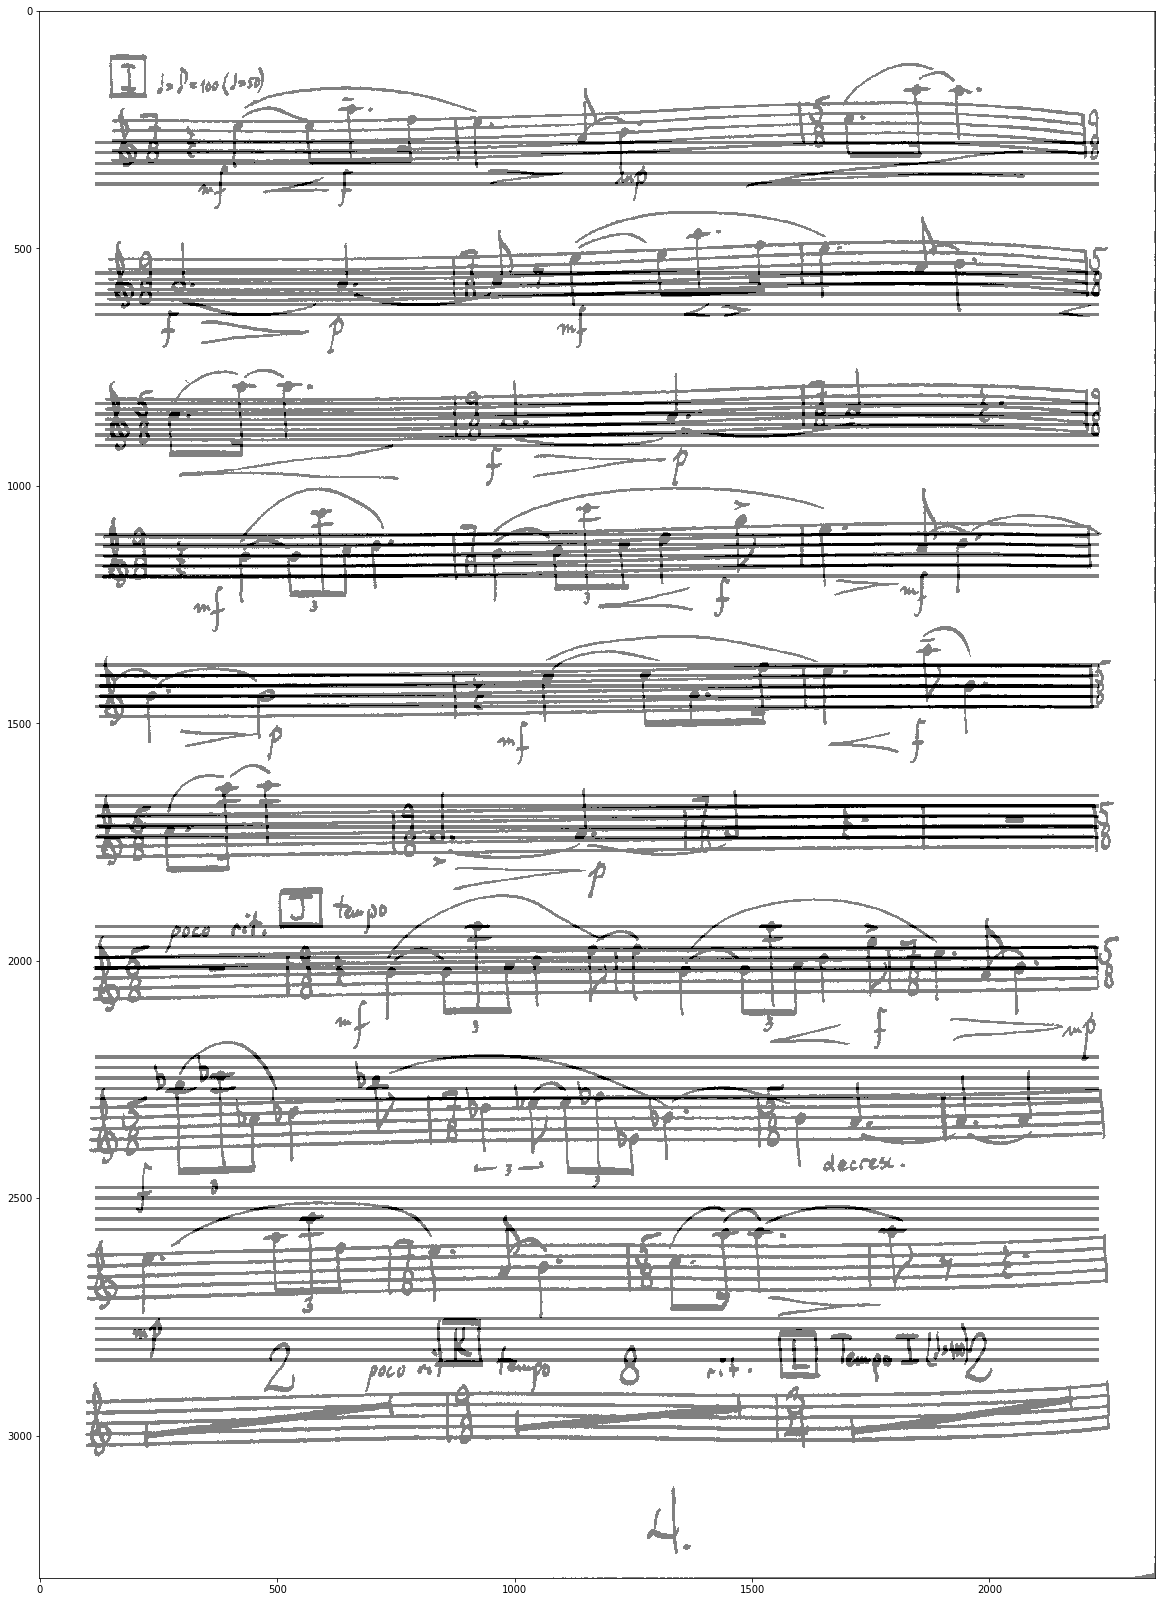

In [66]:
plt.figure(figsize=(20,30))
blank_img2=blank_img
plt.imshow(blank_img2+music, cmap='gray')

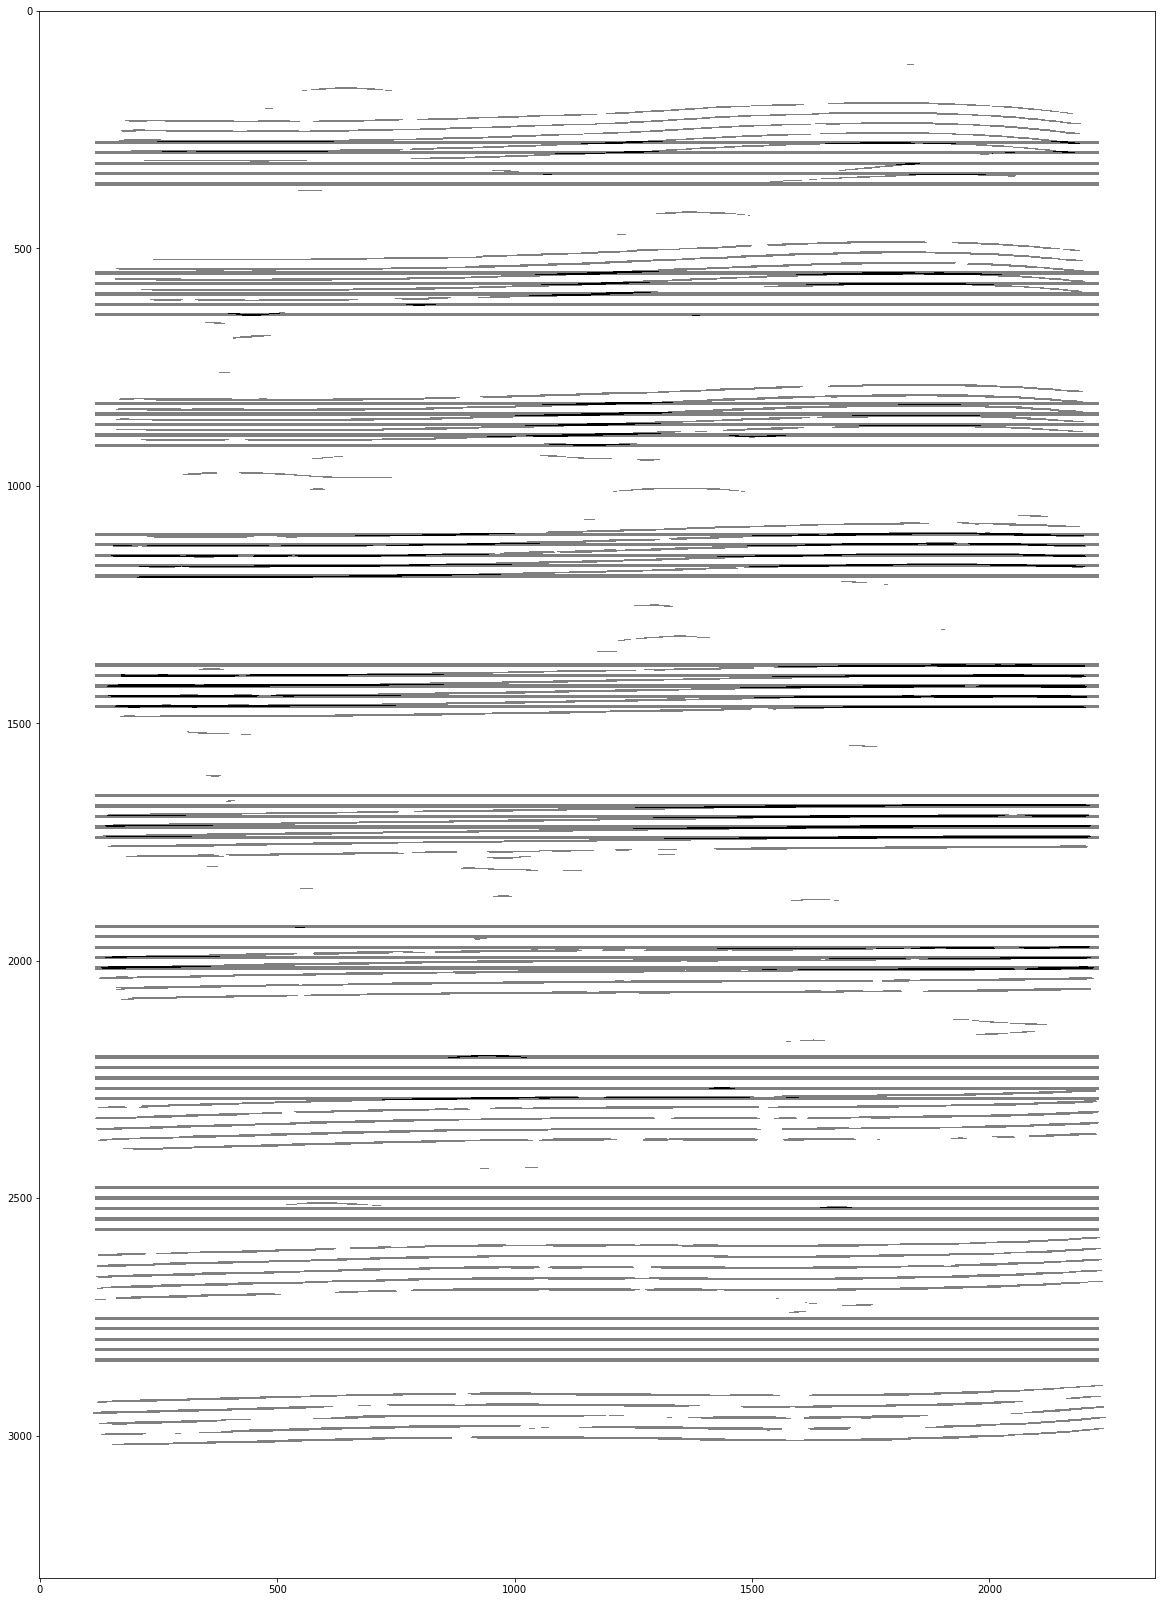

In [67]:
plt.figure(figsize=(20,30))
blank_img2=blank_img
plt.imshow(blank_img2+extracted_staff, cmap='gray')

# Deformation

## Full Image No Initial Alignment

In [35]:


moving = ~music
static = ~(blank_img.astype(np.uint8))

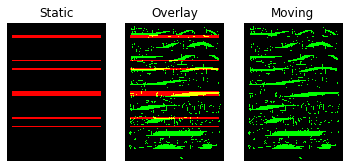

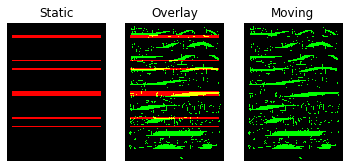

In [36]:
regtools.overlay_images(static, moving, 'Static', 'Overlay', 'Moving',
                        'input_images.png')

In [37]:
dim = static.ndim
metric = SSDMetric(dim)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)



In [38]:
mapping = sdr.optimize(static, moving)

(array([[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     , 127.     , 127.     , ..., 126.99999, 127.     ,
         127.     ],
        [  0.     , 127.     , 127.     , ..., 127.     , 127.00001,
         127.     ],
        ...,
        [  0.     , 127.     , 127.     , ..., 127.     , 127.     ,
         127.     ],
        [  0.     , 127.     , 127.     , ..., 127.     , 127.     ,
         127.     ],
        [  0.     , 127.     , 127.     , ..., 127.     , 127.     ,
         127.     ]], dtype=float32),
 array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
           0.      ],
        [  0.      , 127.      , 127.      , ..., 113.318085, 119.98652 ,
         127.      ],
        [  0.      , 127.      , 127.      , ..., 127.      , 127.      ,
         127.      ],
        ...,
        [  0.      , 127.      , 127.      , ..., 127.00001 , 127.      ,
         127.      ],
        [  0.      , 127.      , 

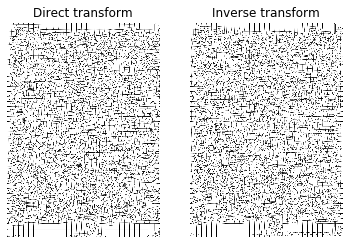

In [39]:
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

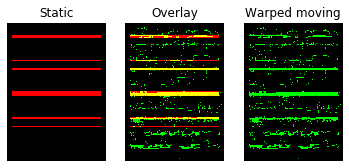

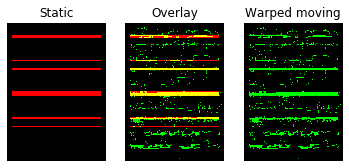

In [40]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static', 'Overlay',
                        'Warped moving', 'direct_warp_result.png')

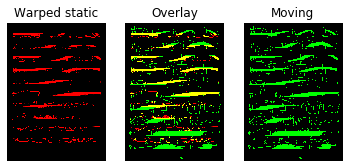

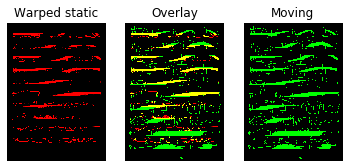

In [41]:
warped_static = mapping.transform_inverse(static, 'linear')
regtools.overlay_images(warped_static, moving, 'Warped static', 'Overlay',
                        'Moving', 'inverse_warp_result.png')

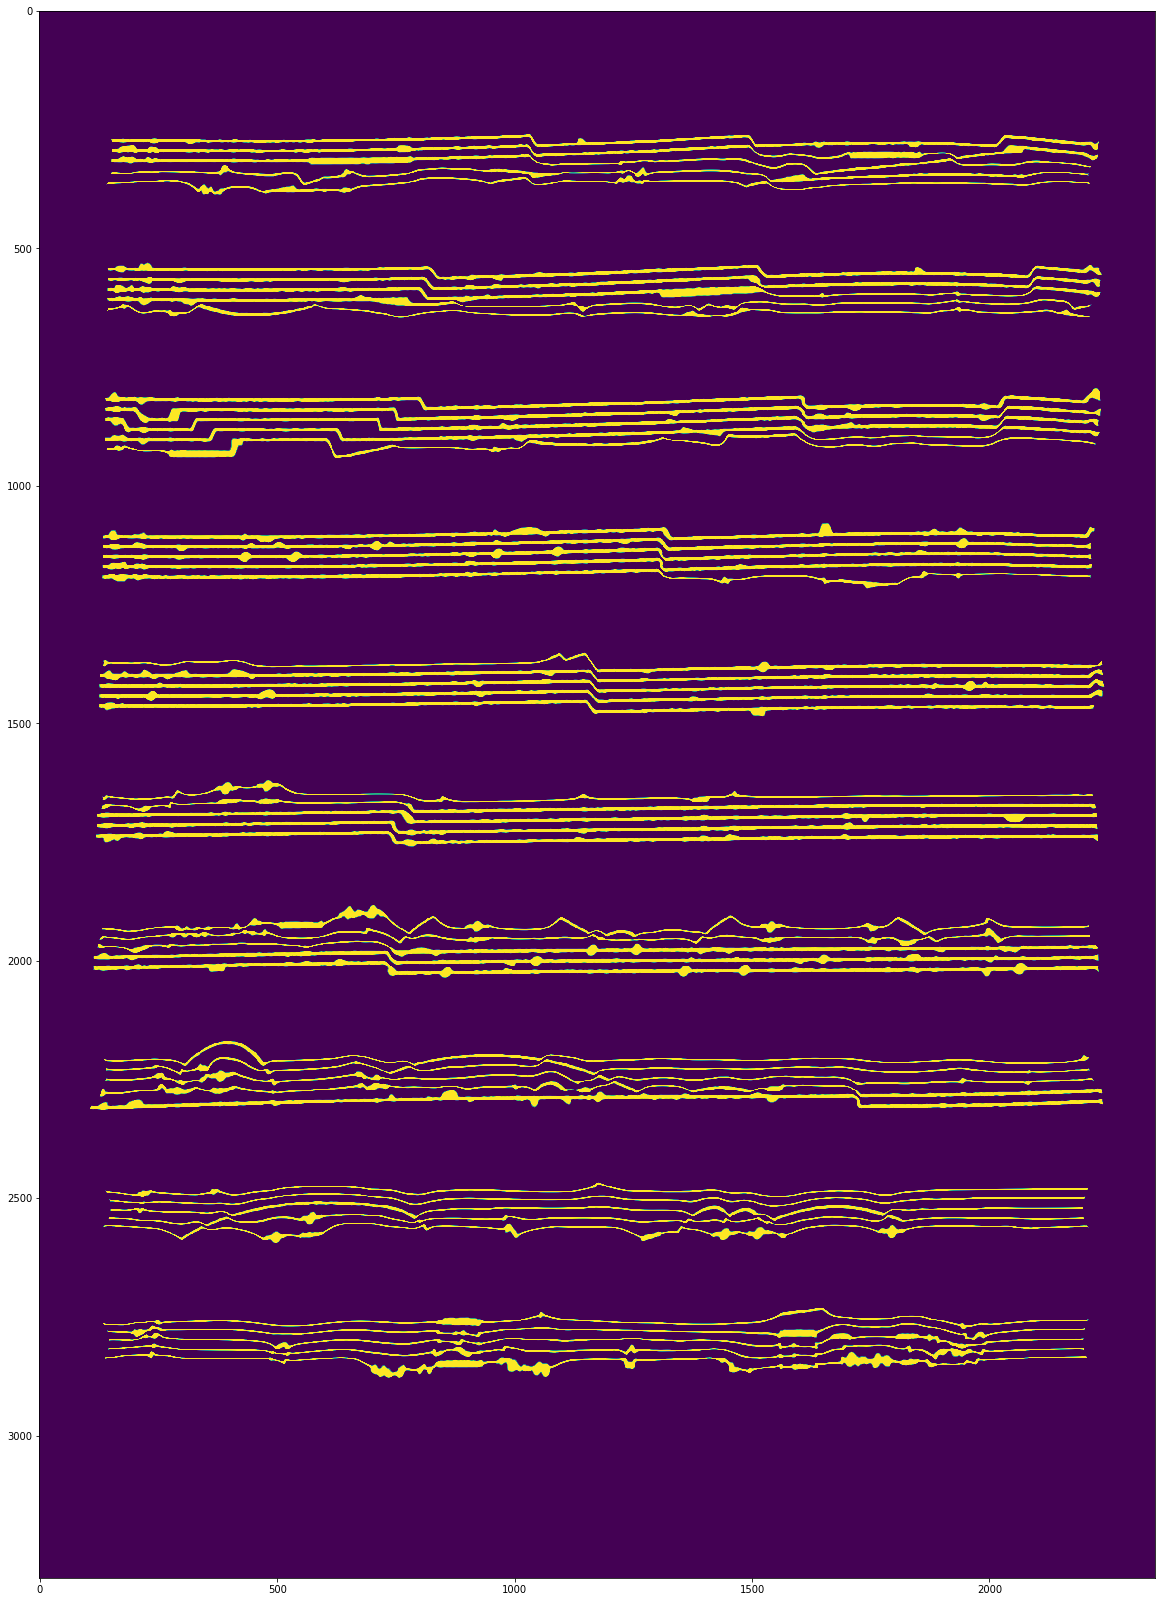

In [42]:
plt.figure(figsize=(20,30))
plt.imshow(warped_static)

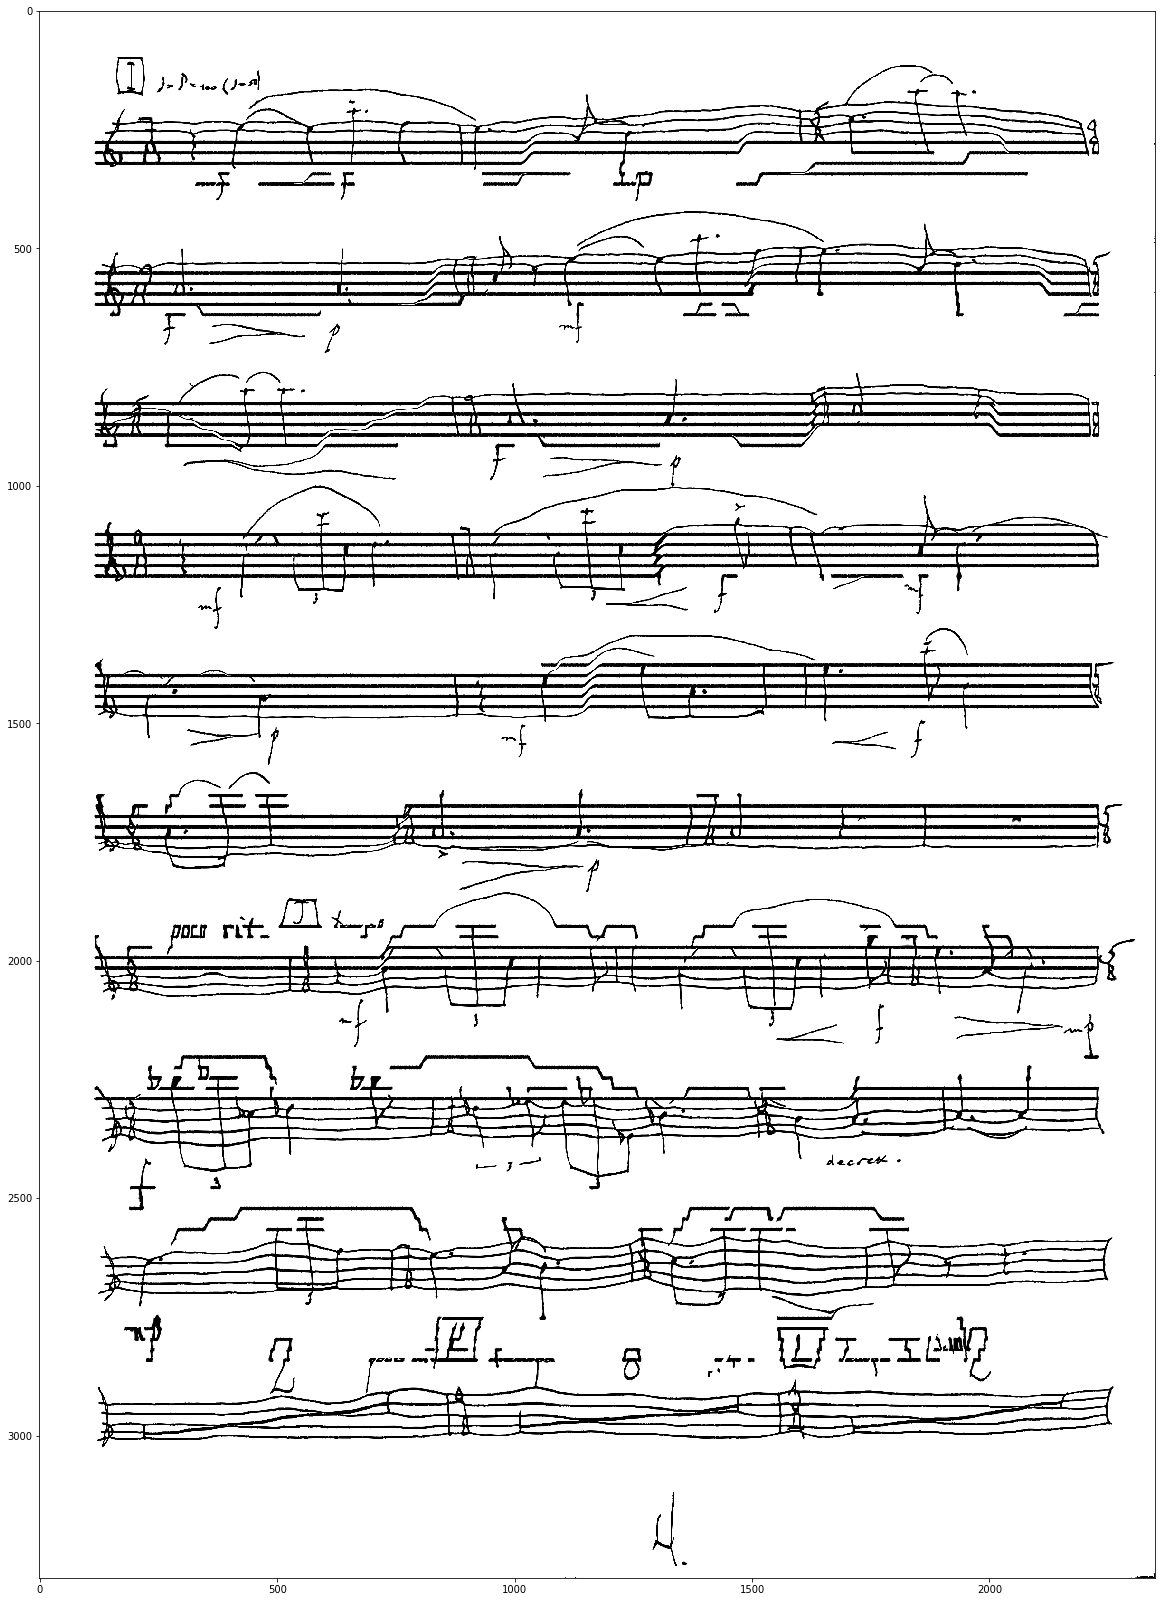

In [46]:
plt.figure(figsize=(20,30))
plt.imshow(~(warped_moving.astype(np.uint8)), cmap=plt.cm.gray)

## Blank Staff No initial Alignment

In [47]:

moving = ~extracted_staff
static = ~(blank_img.astype(np.uint8))

In [48]:
dim = static.ndim
metric = SSDMetric(dim)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)


In [49]:
mapping1 = sdr.optimize(static, moving)

(array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        ...,
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.],
        [  0., 127., 127., ..., 127., 127., 127.]], dtype=float32),
 array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
           0.      ],
        [  0.      , 127.      , 127.      , ..., 127.      , 127.      ,
         127.      ],
        [  0.      , 127.      , 127.      , ..., 127.      , 127.      ,
         127.      ],
        ...,
        [  0.      , 113.721176, 127.00001 , ..., 127.      , 127.      ,
         127.      ],
        [  0.      , 118.66318 , 127.      , ..., 127.      , 127.      ,
         127.      ],
        [  0.      , 127.      , 127.      , ..., 127.      , 127.      ,
         127.      ]], dtype=float32))

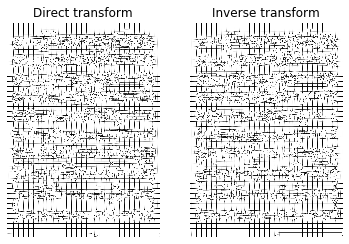

In [50]:
regtools.plot_2d_diffeomorphic_map(mapping1, 10, 'diffeomorphic_map.png')

In [53]:
warped_moving = mapping1.transform(moving, 'linear')
warped_static = mapping1.transform_inverse(static, 'linear')

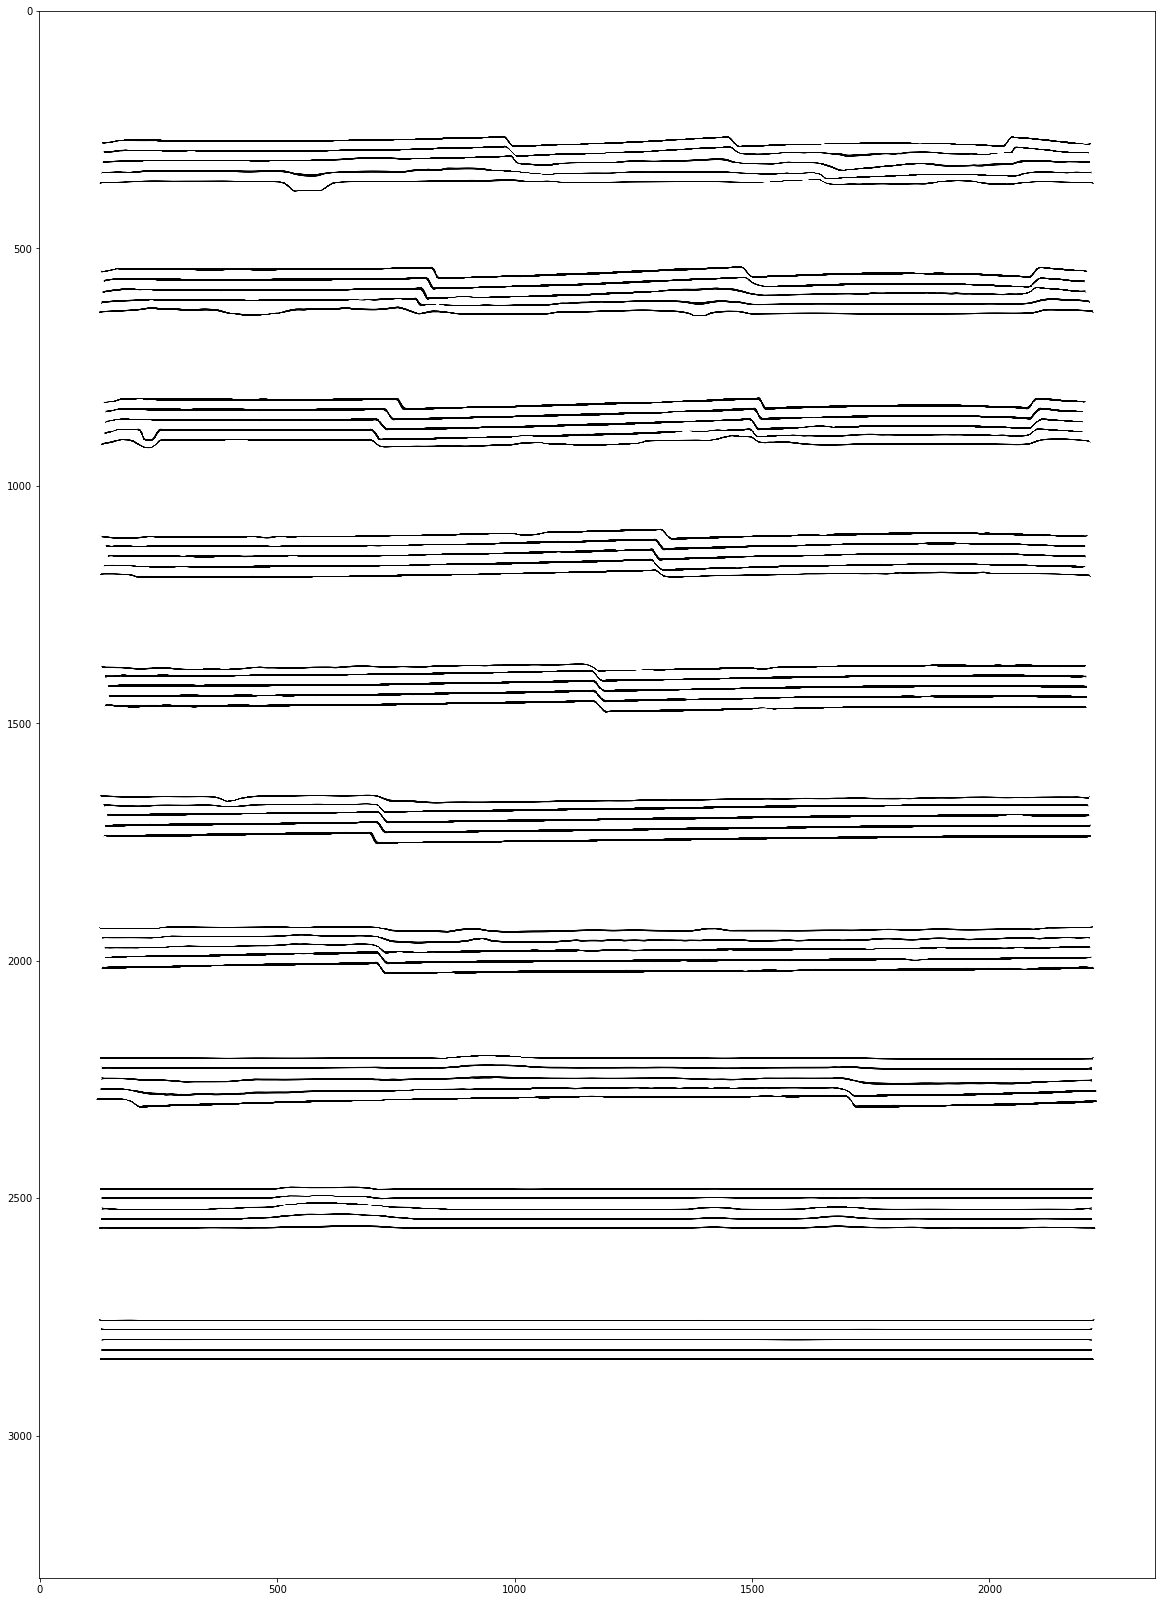

In [54]:
plt.figure(figsize=(20,30))
plt.imshow(~(warped_static.astype(np.uint8)), cmap='gray')

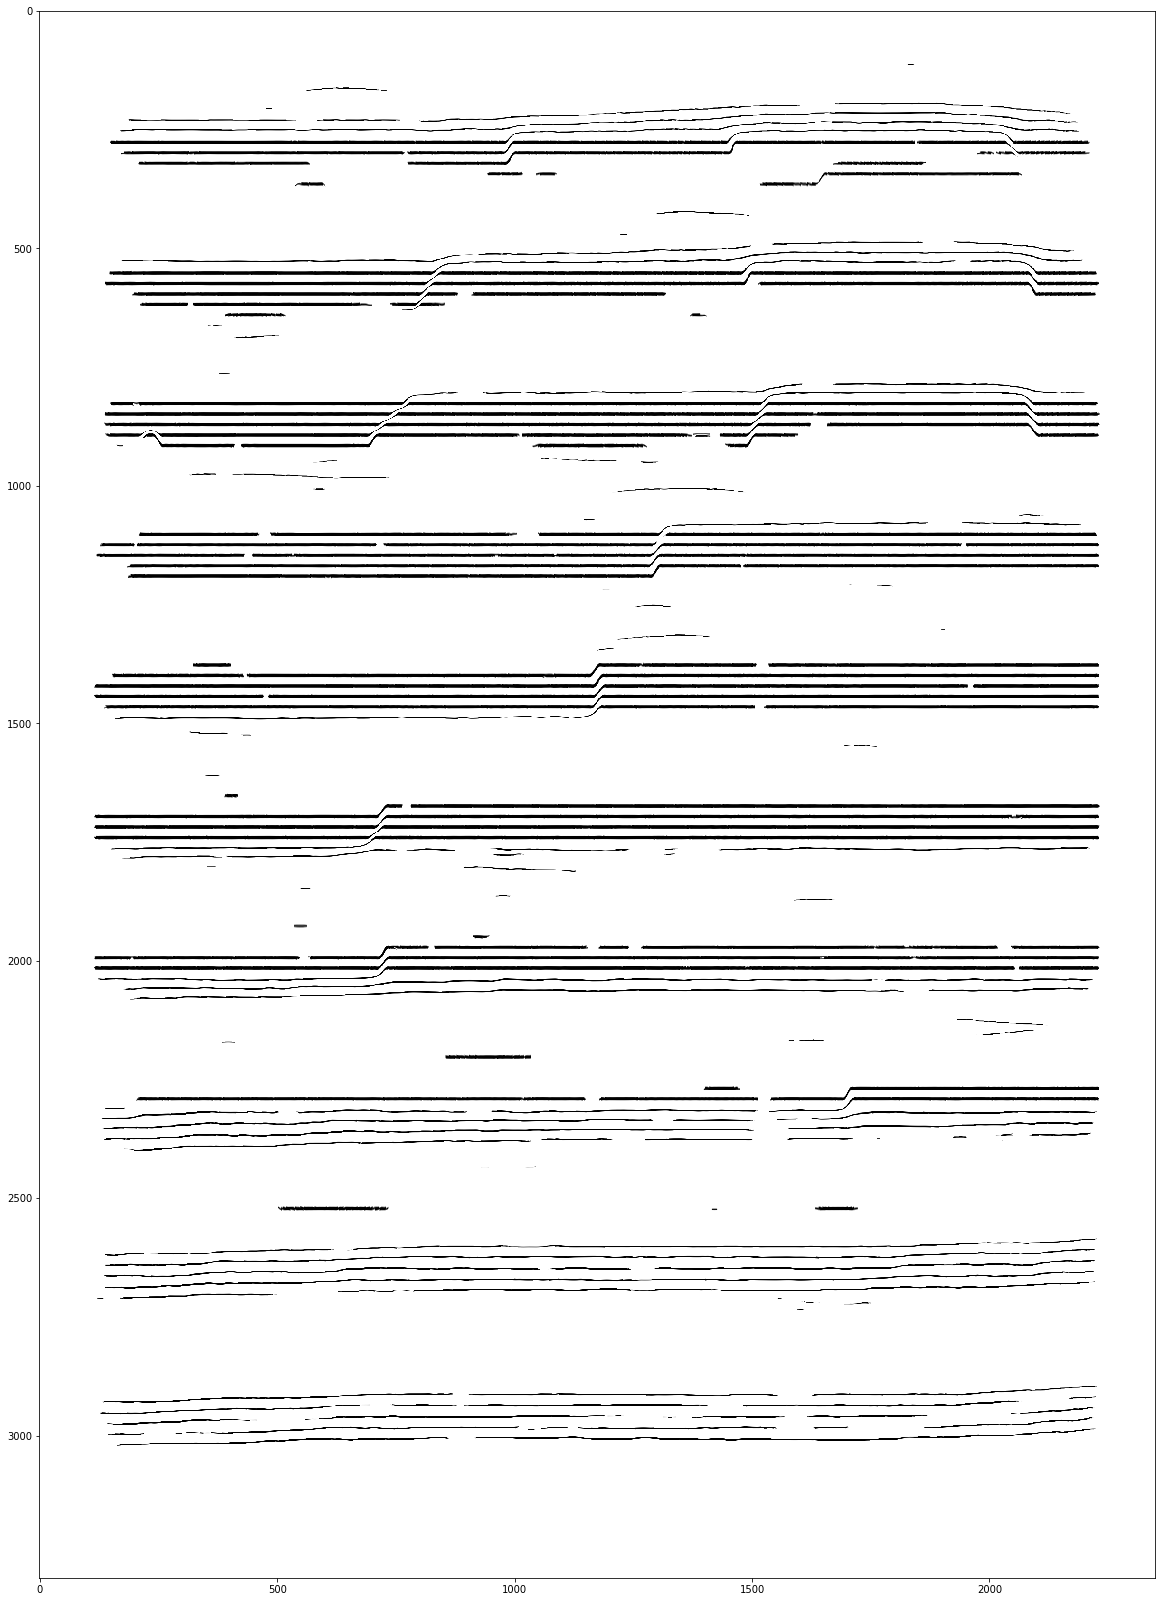

In [55]:
plt.figure(figsize=(20,30))
plt.imshow(~(warped_moving.astype(np.uint8)), cmap=plt.cm.gray)

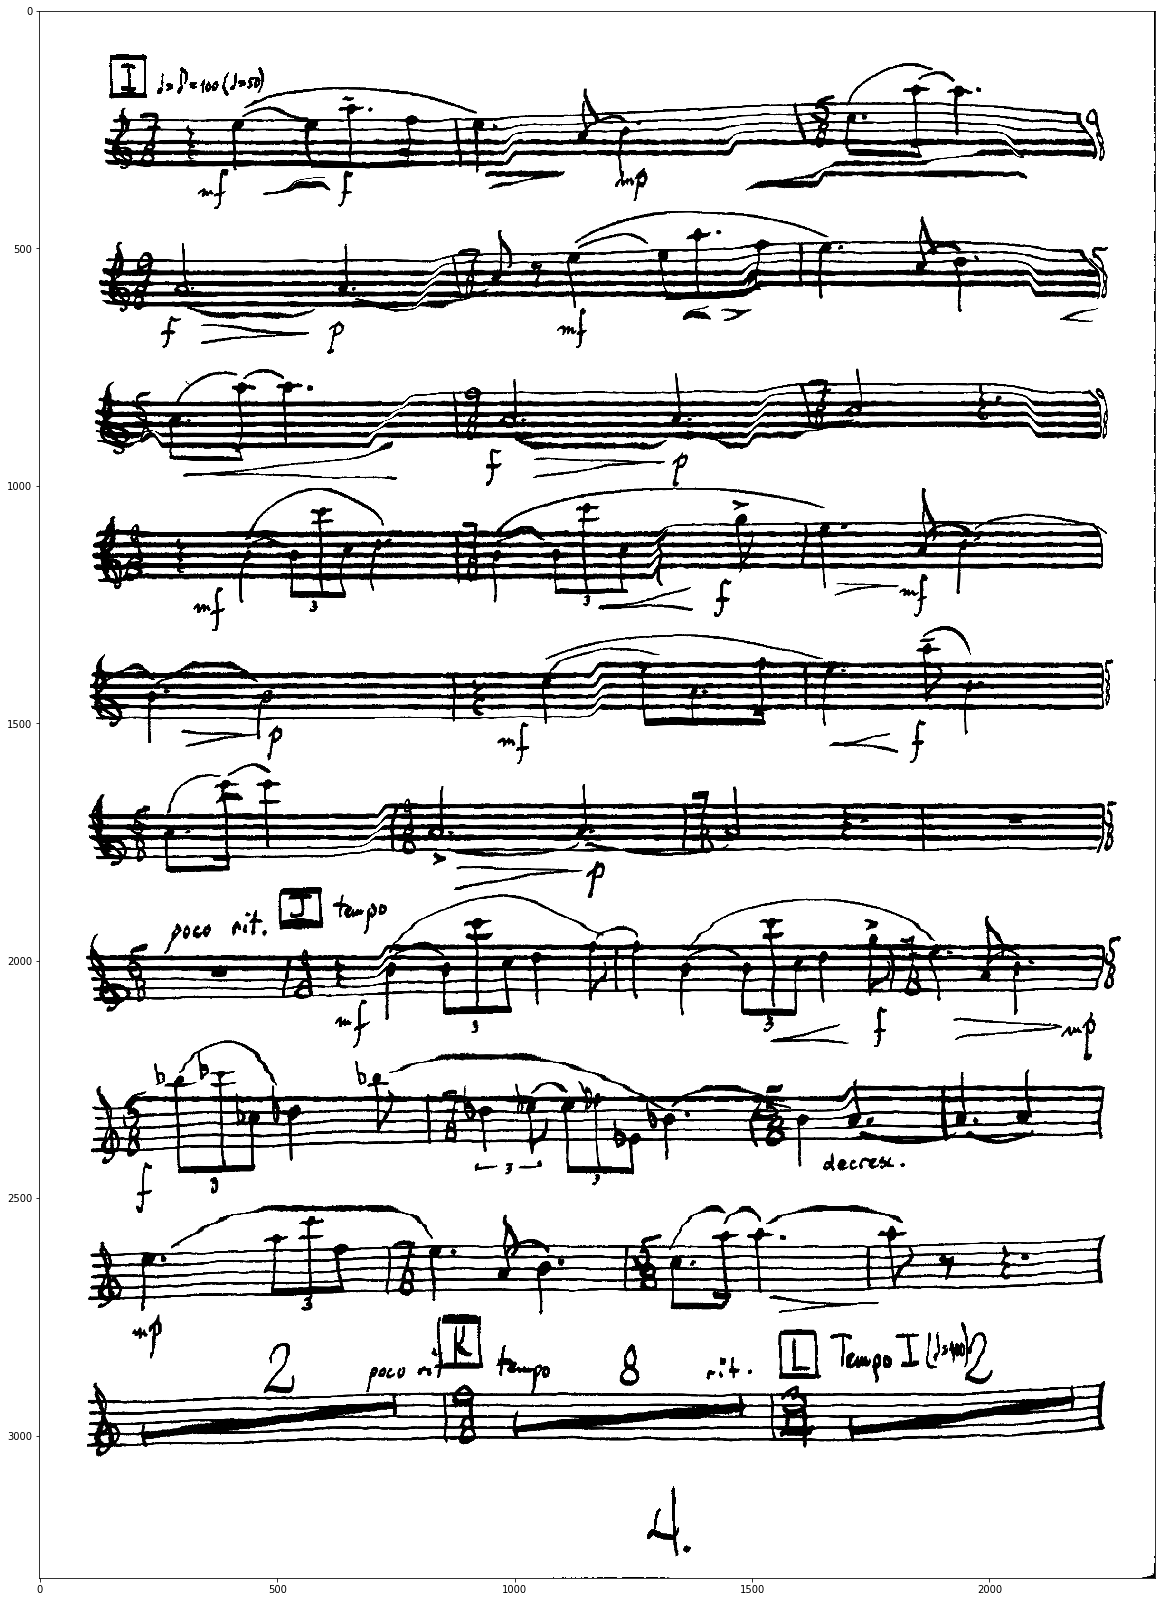

In [60]:
warped_music = mapping1.transform(~music, 'linear')
plt.figure(figsize=(20,30))
plt.imshow(~(warped_music.astype(np.uint8)), cmap=plt.cm.gray)

# Rigid Registration

    1.Register blank image to music. 
    2.Correct for shift in theta
    3.Correct staffline thickness

## Affine Registration (Powell's Method Optimization)

In [111]:
'''
Optimizing two properties: 
1-scale_rows, 
2-shift_row, 
3 -shift_col
4 - scale_cols
5 - theta
'''


def f(x, ref_img, comp_img):
    scale_row=x[0]
    shift_row =x[1]
    shift_col=x[2]
    scale_col = x[3]

    
 
    
    scale_translation_matrix = np.array([[scale_row, 0,         shift_row],
                                   [0,         scale_col, shift_col],
                                   [0,         0,         1       ]])   
 

    comp_img1 = affine_transform(comp_img, scale_translation_matrix)
    
    ssd = np.sum((comp_img1 - ref_img) ** 2)
    print(ssd)

    
    return ssd


In [110]:
'''
Optimizing two properties: 
1-scale_rows, 
2-shift_row, 
3 -shift_col
4 - scale_cols
5 - theta
'''


def f_output(x, ref_img, comp_img):
    scale_row=x[0]
    shift_row =x[1]
    shift_col=x[2]
    scale_col = x[3]

    
 
    
    scale_translation_matrix = np.array([[scale_row, 0,         shift_row],
                                   [0,         scale_col, shift_col],
                                   [0,         0,         1       ]])   
 

    comp_img1 = affine_transform(comp_img, scale_translation_matrix)
    
    ssd = np.sum((comp_img1 - ref_img) ** 2)
    print(ssd)
    plt.figure(figsize=(20,30))
    plt.imshow(comp_img1+ref_img)
    
    return comp_img1, comp_img1+ref_img


38958268

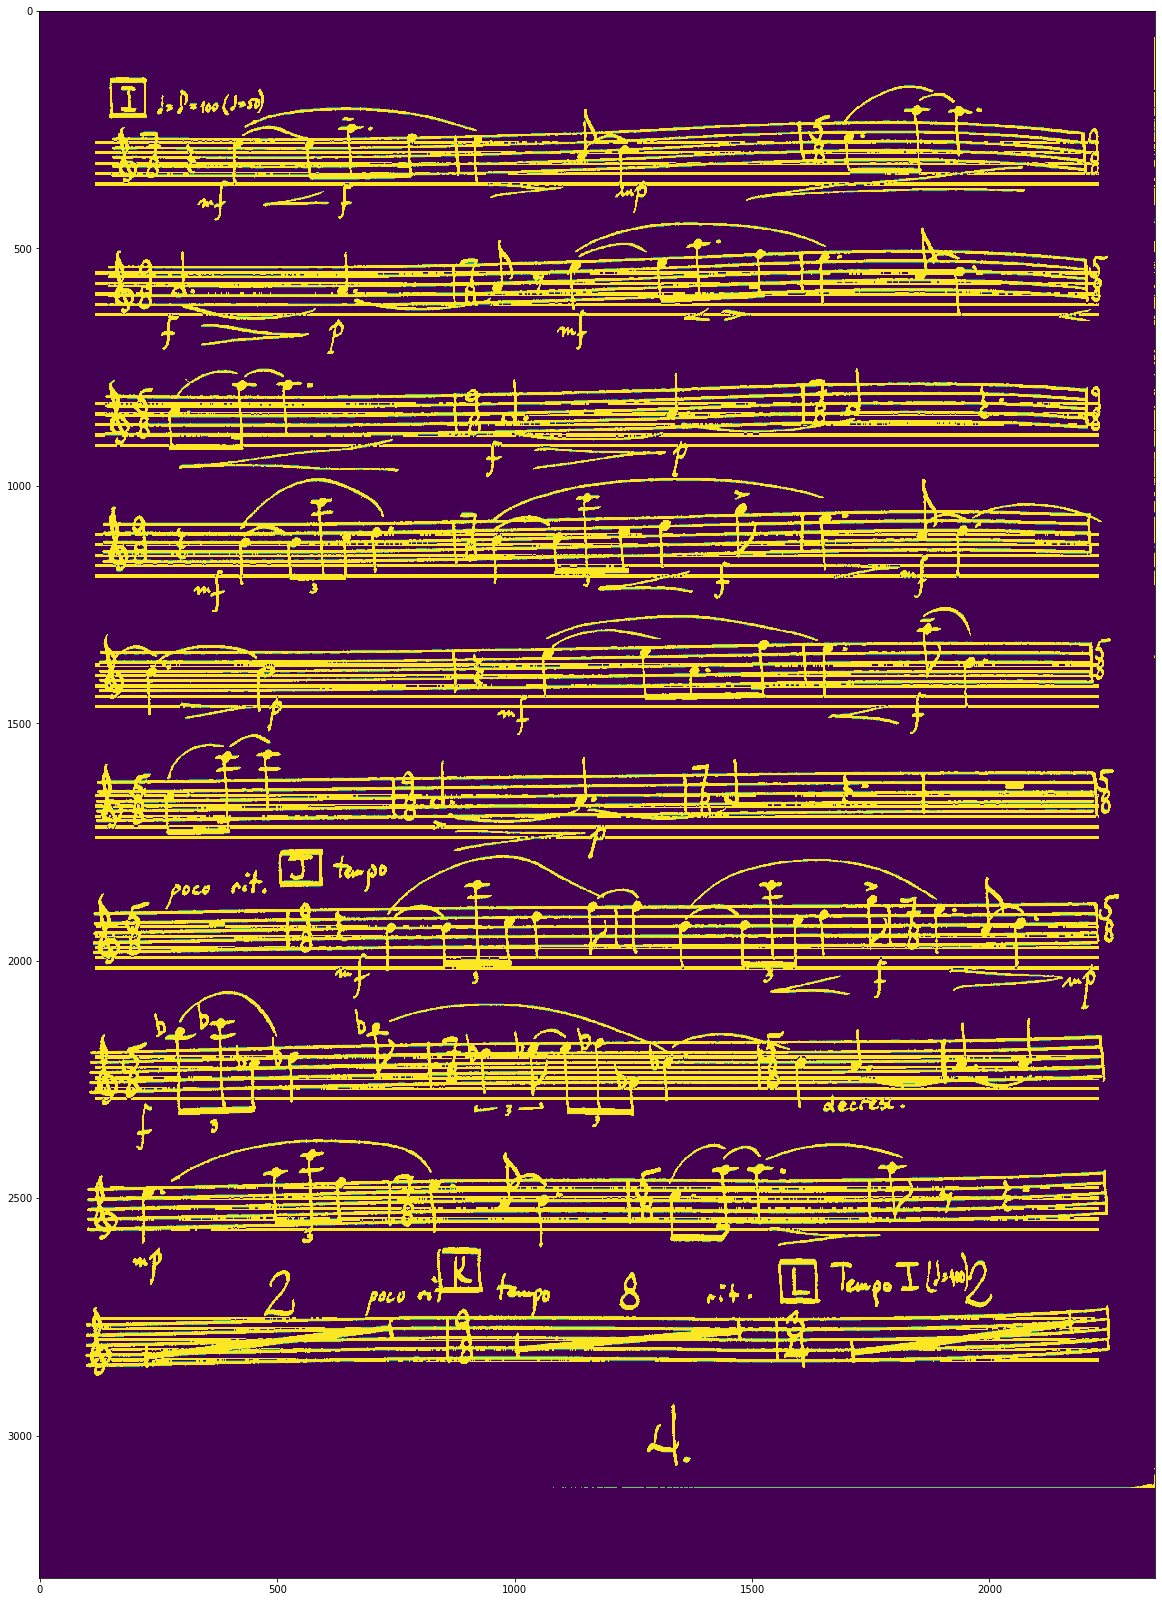

In [101]:
x=[1.08, -60, 0, 1]
f(x, ~blank_img.astype(np.uint8), ~music.astype(np.uint8) )

In [104]:
'''
Use Powell's method to optimize
'''
a = optimize.minimize(f, [1,0,0,1], args = (blank_img, music), method='Powell', tol=30000000)
                                                                                                             
                                                                                                        
                                                                                                            
       

97487170650.0
97487170650.0
279588122550.0
455981440050.0
97487170650.0
102135185274.0
205648835007.0
101683247475.0
161901803476.0
104284259746.0
120588464375.0
103106589155.0
103956734609.0
95862437109.0
95862437109.0
95672494110.0
96578138806.0
95672494110.0
95672494110.0
95878592250.0
94946143218.0
95945307615.0
94946143218.0
94946143218.0
276263599546.0
456134118750.0
94946143218.0
87902224996.0


In [107]:
a.x

array([ 0.98349996,  1.        , -1.618034  ,  0.38196603])

38958268


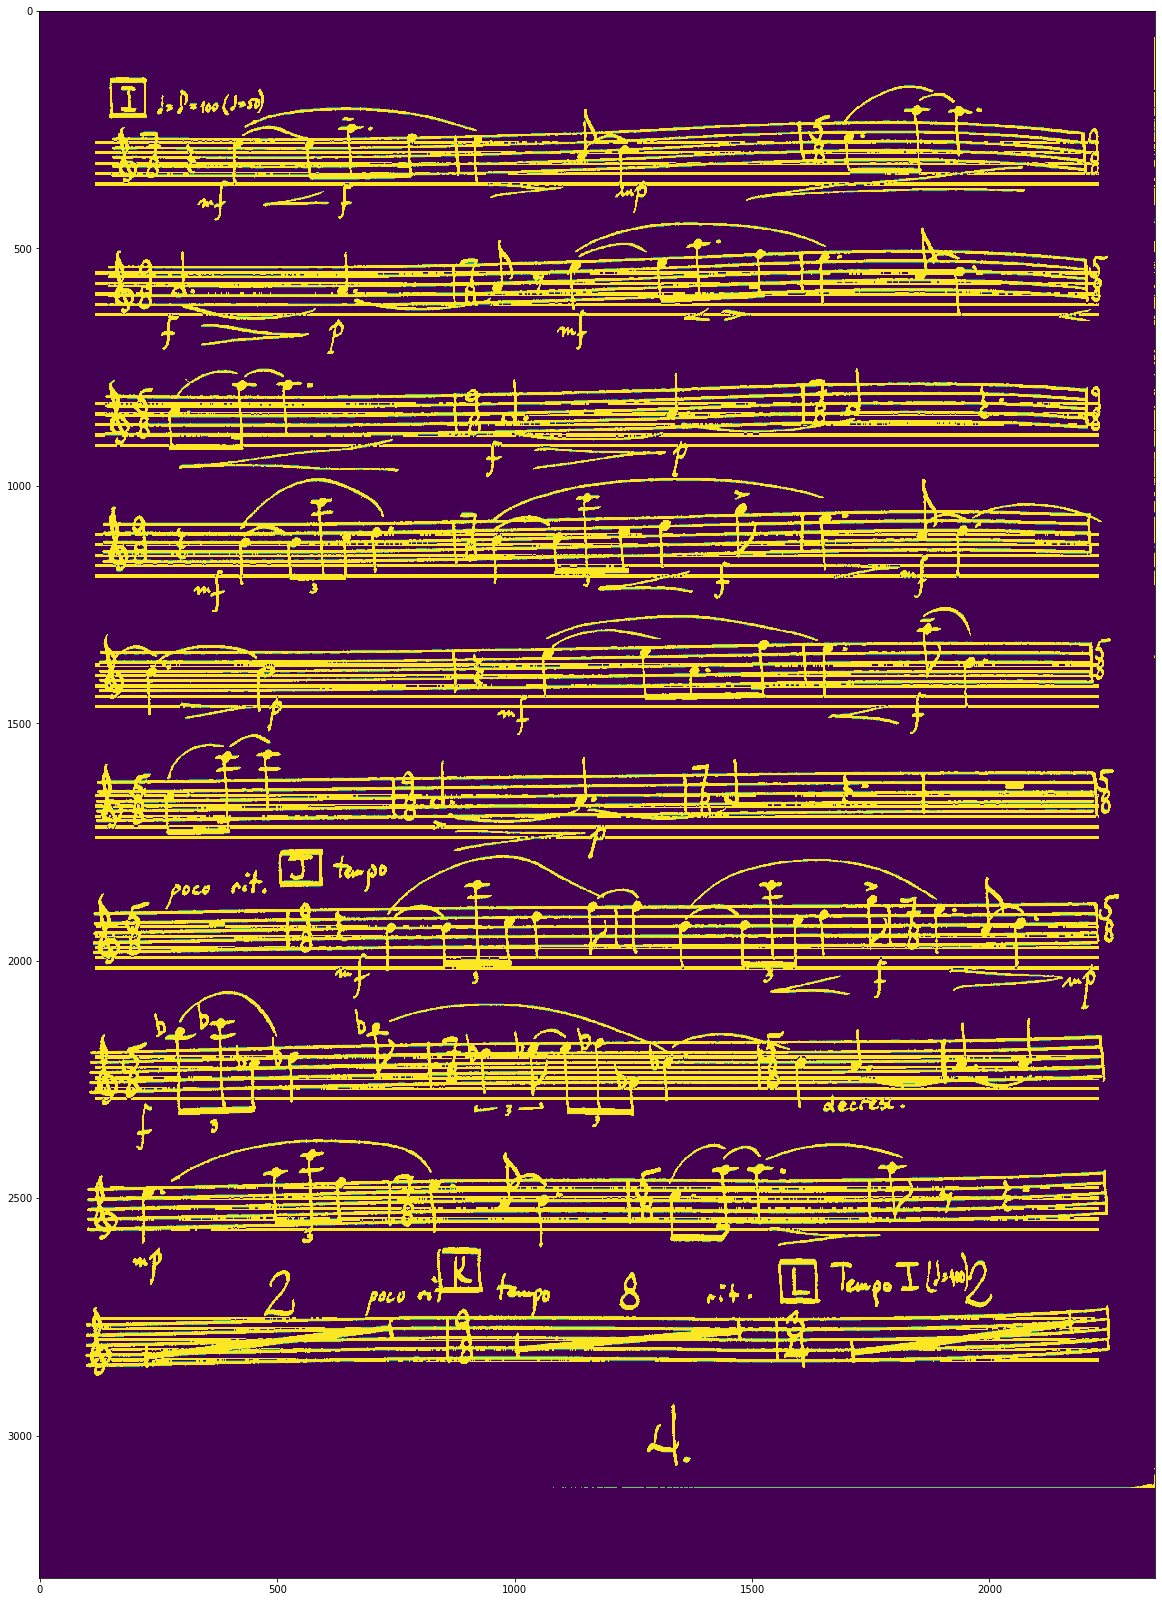

In [130]:
shifted, comb = f_output(x, ~blank_img.astype(np.uint8), ~music.astype(np.uint8) )

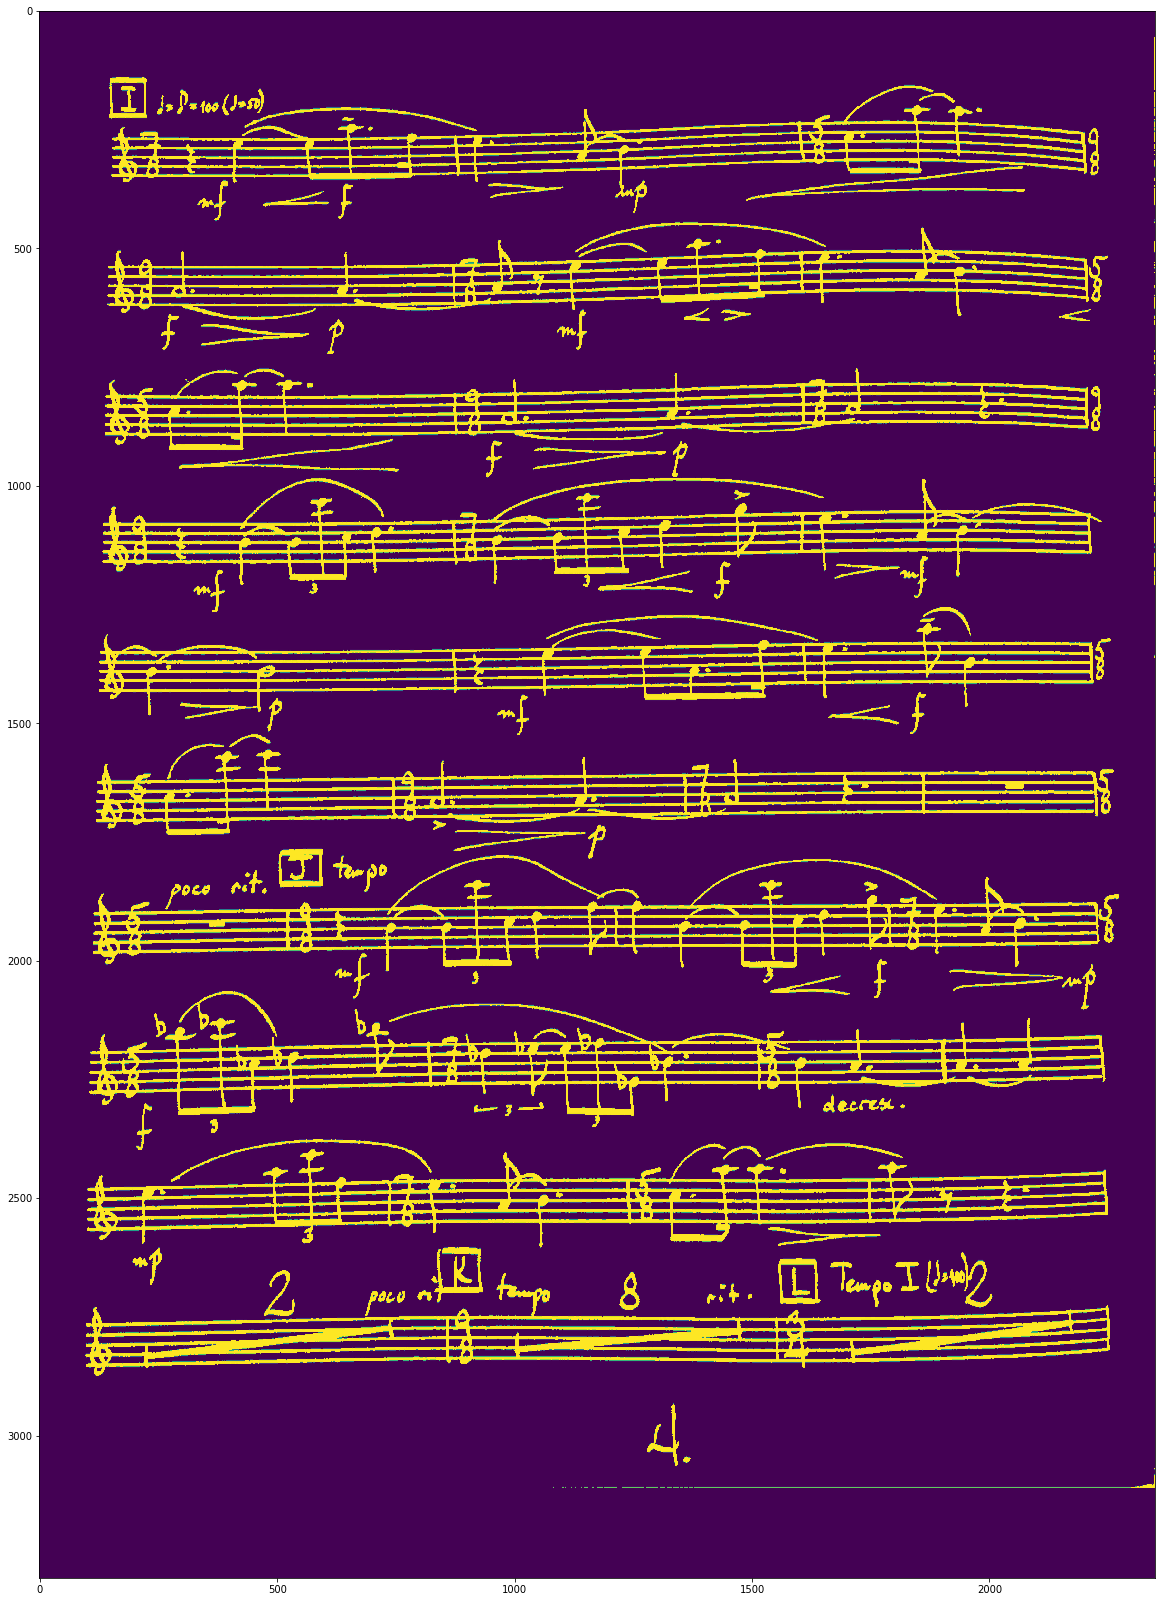

In [131]:
plt.figure(figsize=(20,30))
plt.imshow(shifted)

In [113]:
shifted.shape

(3300, 2350)

In [114]:
comb.shape

(3300, 2350)

# Full Music Deformation with Affine Registered Image

In [116]:

moving = ~music
static = ~(shifted.astype(np.uint8))

In [117]:
dim = static.ndim
metric = SSDMetric(dim)
level_iters = [200, 100, 50, 25]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50)


In [118]:
mapping2 = sdr.optimize(static, moving)

In [121]:
warped_moving = mapping2.transform(moving, 'linear')
warped_static = mapping2.transform_inverse(static, 'linear')

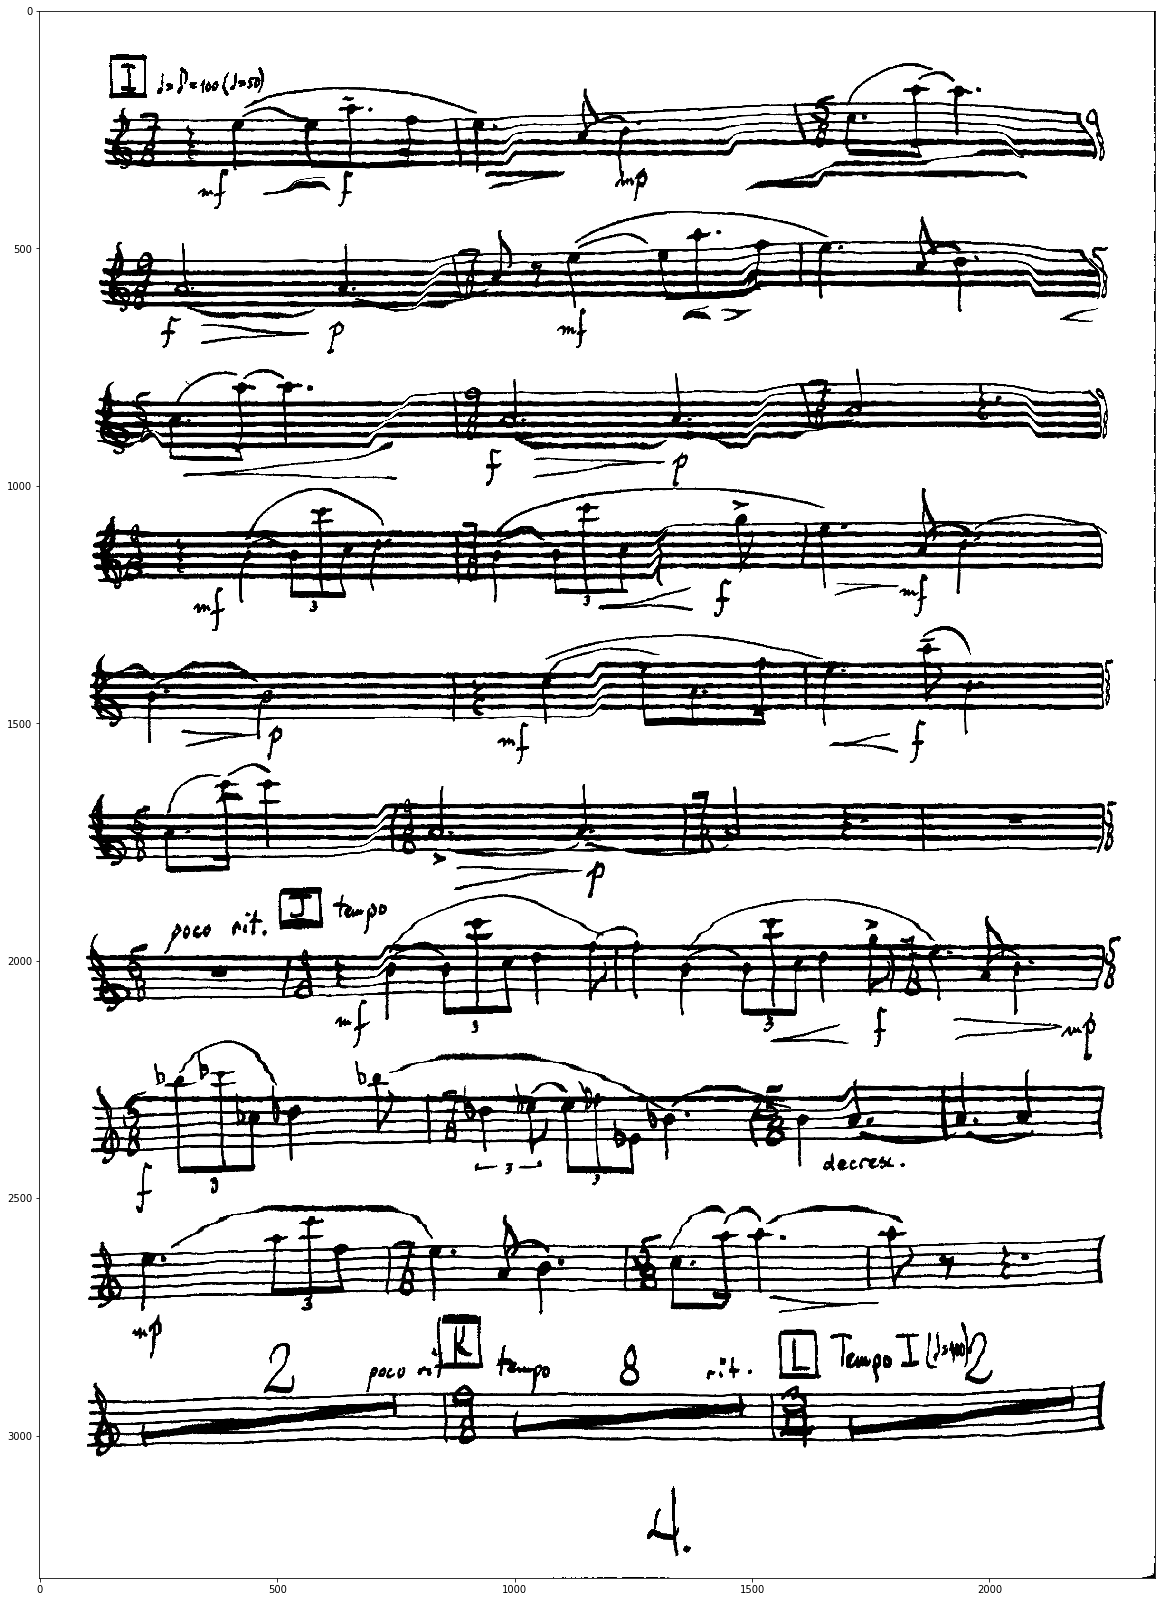

In [125]:
plt.figure(figsize=(20,30))
plt.imshow(~(warped_music.astype(np.uint8)), cmap=plt.cm.gray)

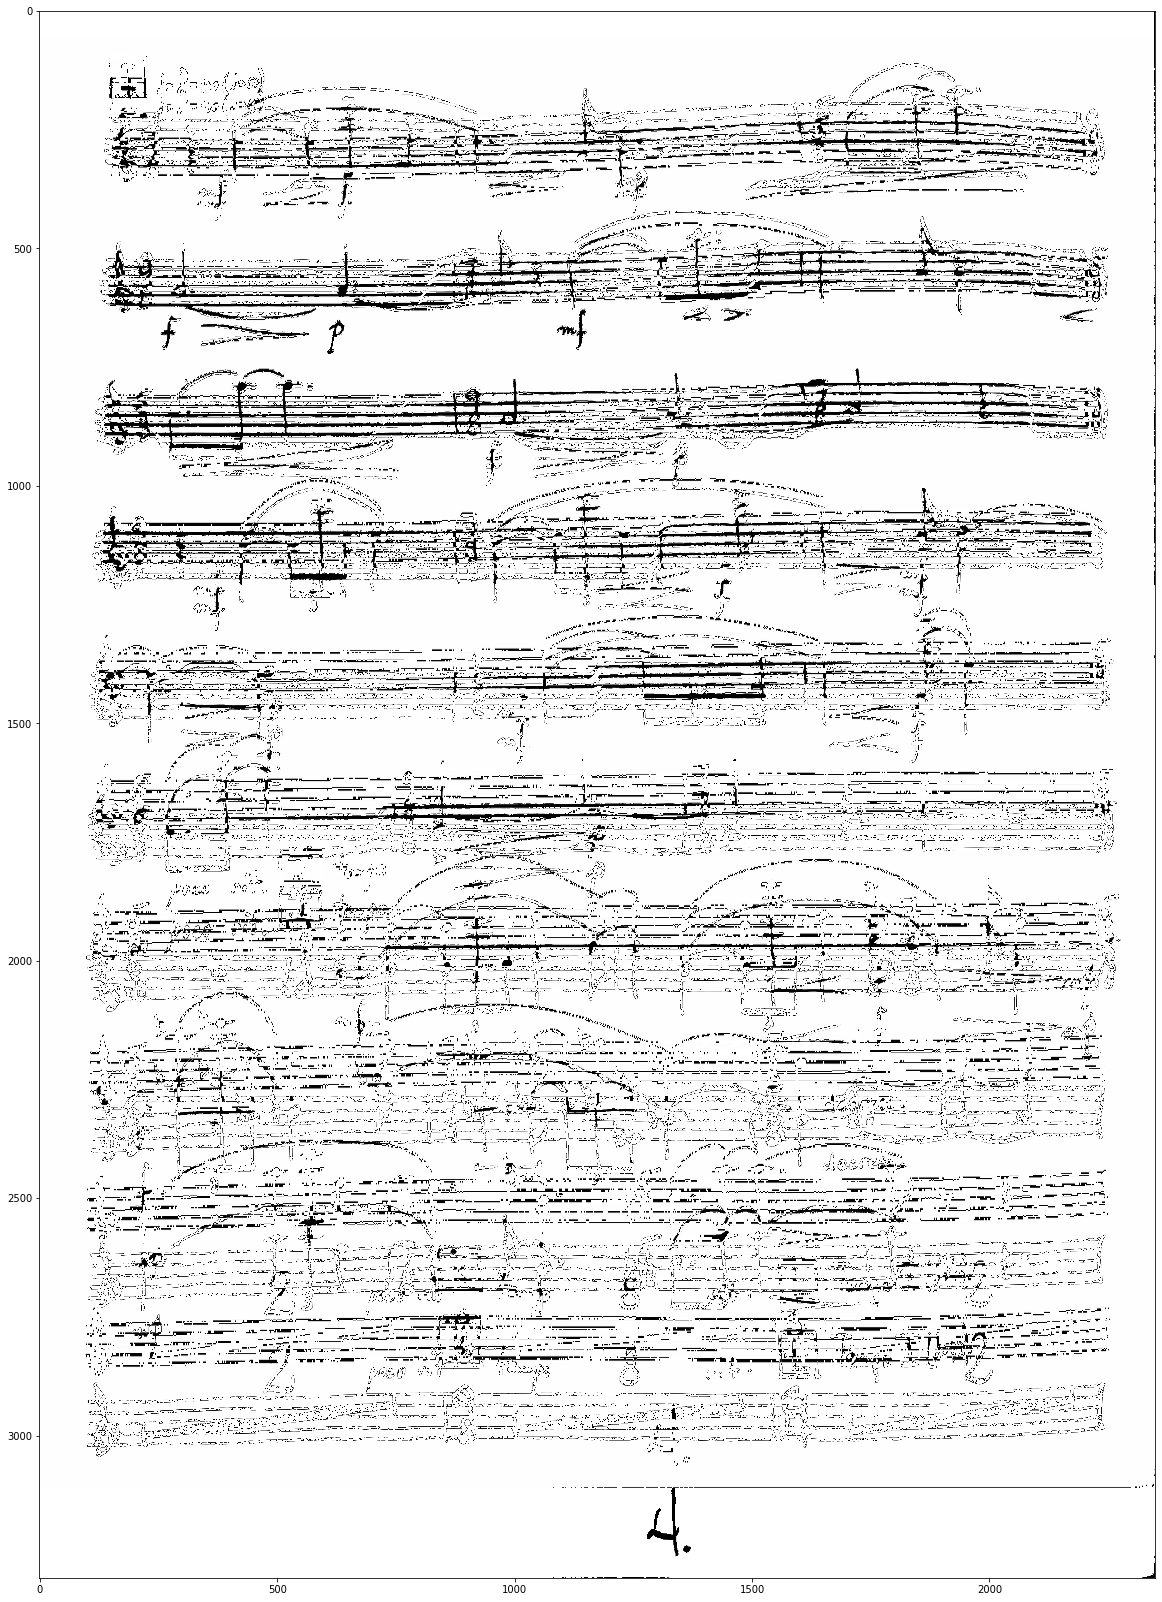

In [124]:
plt.figure(figsize=(20,30))
plt.imshow(~(warped_music.astype(np.uint8))+shifted, cmap=plt.cm.gray)

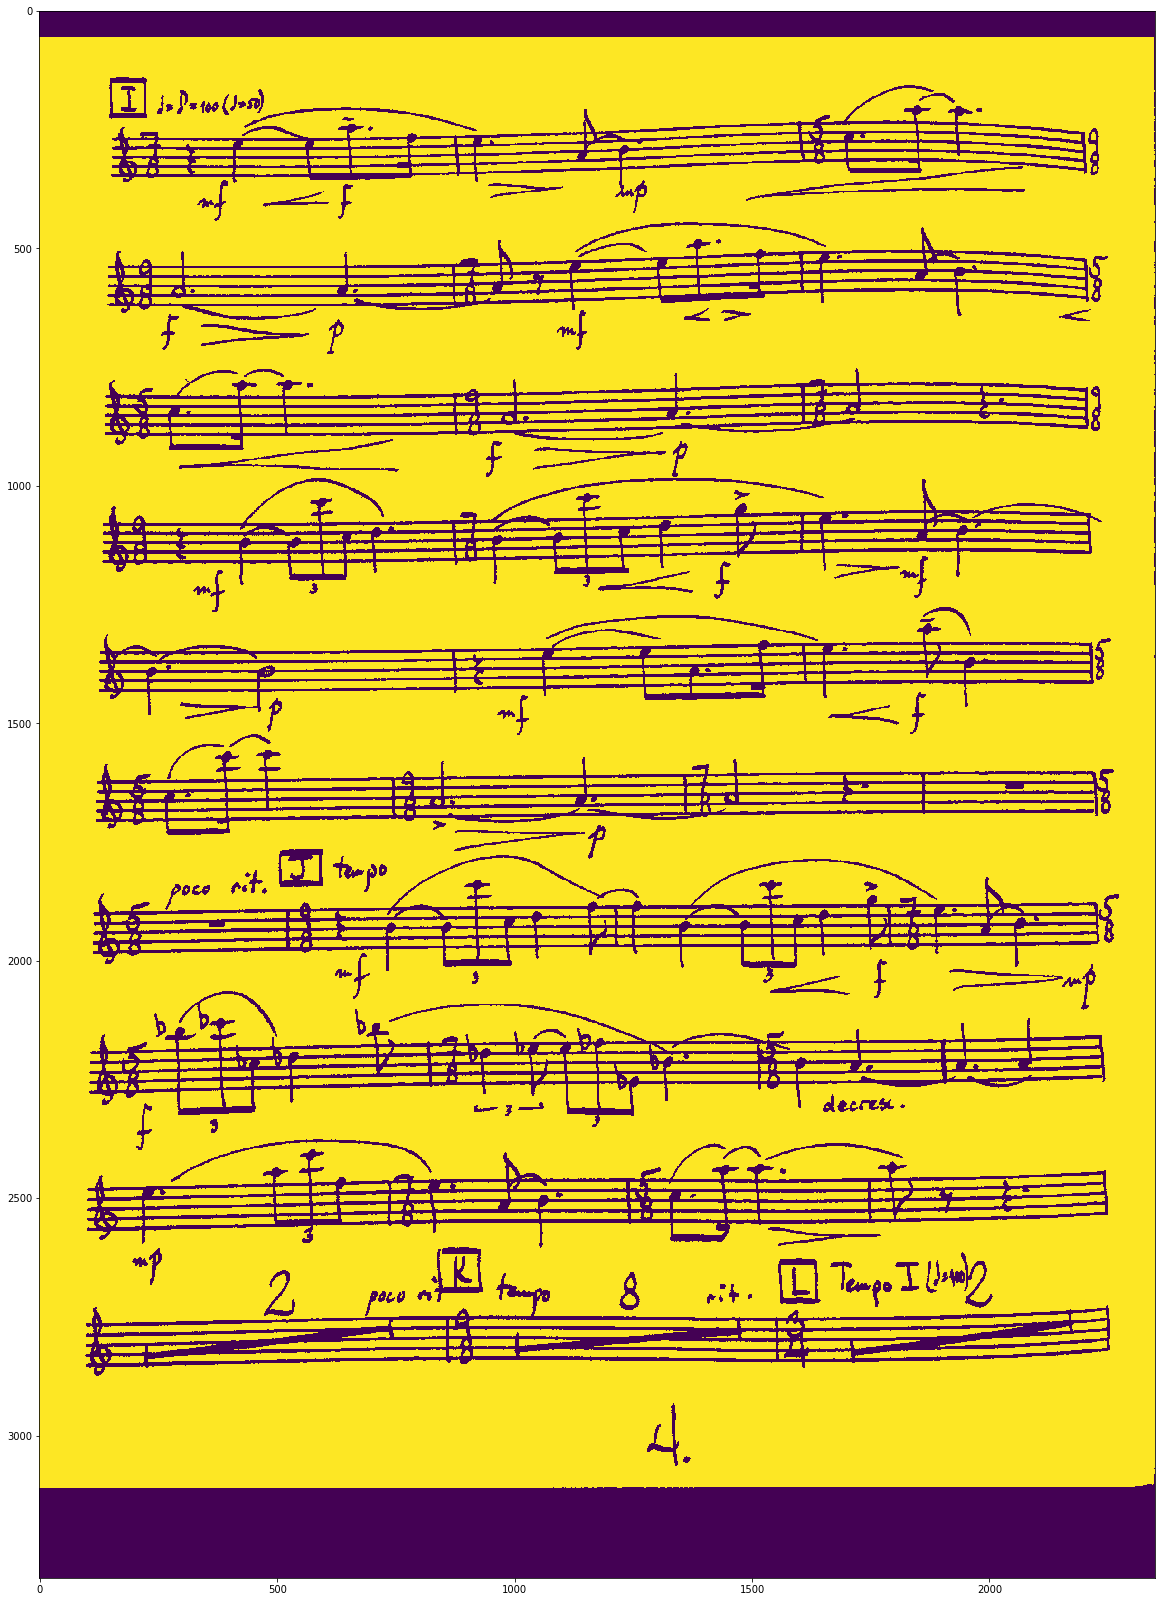

In [128]:
shifted_thresh = filters.threshold_otsu(shifted)
shifted[shifted > shifted_thresh]=255
shifted[shifted <= shifted_thresh]=0
    
plt.figure(figsize=(20,30))
plt.imshow(shifted)

# Staff line Deformation with Affine Registered Image

In [132]:
moving = ~extracted_staff
static = shifted

In [ ]:
dim = static.ndim
metric = SSDMetric(dim)
level_iters = [200, 100, 50]
sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter=50, opt_tol=1e-02)
SymmetricDiffeomorphicRegistration?


In [134]:
mapping3=sdr.optimize(static, moving)

KeyboardInterrupt: 

In [135]:
SymmetricDiffeomorphicRegistration?


### Gaussian pyramid?

In [ ]:
#Blur
blur1 = resize(ndimage.gaussian_filter(extracted_staff, sigma=5), \
               .75*extracted_staff.shape)
#resize

In [24]:
music.shape

(3300, 2350)

# Removal with Fourier 